In [1]:
import pandas as pd
import json
import gzip
import glob
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Brands Preparation

In [2]:
brands = pd.read_csv("brands.csv")

In [3]:
# eliminate the composite values to obey the NF1, generate a new table called brand_relationship
related_brands = brands[~brands["RELATED_BRAND_IDS"].isna()].loc[:, ["ID", "RELATED_BRAND_IDS"]]

idx = 0
brands_relationship = pd.DataFrame(columns = ["brand1_id", "brand2_id"])
for i in range(0, len(related_brands)):
    brand_id = related_brands.iat[i, 0]
    related_brand_ids = related_brands.iloc[i, 1].split(" : ")
    for j in related_brand_ids:
        brands_relationship.loc[idx] = [brand_id, j]
        idx += 1;

In [4]:
# eliminate the attributes depend on the primary key and other attributes to obey NF3, generate a new table called categories
categories_elements = brands["CATEGORY"].unique().reshape(-1, 1)
categories_code_elements = brands["CATEGORY_CODE"].unique().reshape(-1, 1)
data = np.concatenate((categories_elements, categories_code_elements), axis = 1)
categories = pd.DataFrame(data, columns =["CATEGORY", "RELATED_BRAND_IDS"])

In [5]:
brands = brands.drop(columns=["CATEGORY", "RELATED_BRAND_IDS"])

In [6]:
# remove the duplicate rows
brands = brands[~brands.duplicated()]

### Receipts Preparation

In [7]:
receipts = pd.read_csv("receipts.csv")

In [8]:
receipts.head()

,ID,STORE_NAME,PURCHASE_DATE,PURCHASE_TIME,DATE_SCANNED,TOTAL_SPENT,REWARDS_RECEIPT_STATUS,USER_ID,USER_VIEWED,PURCHASED_ITEM_COUNT,...,PENDING_DATE,MODIFY_DATE,FLAGGED_DATE,PROCESSED_DATE,FINISHED_DATE,REJECTED_DATE,NEEDS_FETCH_REVIEW,DIGITAL_RECEIPT,DELETED,NON_POINT_EARNING_RECEIPT
0,62868f660a72546bef0b2dd0,TOWN OF ROCKY MOUNT,2022-05-19T00:00:00Z,2:05 PM,2022-05-19T18:41:42.53Z,859.87,FINISHED,61375682c625197c5db73602,True,1.0,...,2022-05-19T18:57:57.228Z,2022-05-22T11:20:57.998Z,2022-05-19T18:42:57.042Z,NaN,2022-05-19T18:57:57.336Z,NaN,NaN,False,NaN,True
1,6096b7370a7216d316001149,NaN,NaN,NaN,2021-05-08T16:07:19.03Z,NaN,SUBMITTED,60047e8a2d7db612a69d2e18,True,NaN,...,NaN,2021-05-08T16:07:19.03Z,NaN,NaN,NaN,NaN,NaN,False,NaN,NaN
2,6269a4ea0a7241077408b6e1,FAMILY DOLLAR,2022-04-27T00:00:00Z,4:15 PM,2022-04-27T20:17:46.09Z,11.00,FINISHED,61578e96c2fb9321213720fc,True,2.0,...,2022-04-27T20:17:54.214Z,2022-04-27T20:17:55.521Z,NaN,NaN,2022-04-27T20:17:54.394Z,NaN,NaN,False,NaN,False
3,625b25e70a723eb9730d2c9c,PUBLIX,2022-04-15T00:00:00Z,4:45 PM,2022-04-16T20:24:07.259Z,10.67,FINISHED,6048de2ec9106b12d2b1ff61,True,4.0,...,2022-04-16T20:24:23.399Z,2022-04-16T20:24:24.064Z,NaN,NaN,2022-04-16T20:24:23.598Z,NaN,NaN,False,NaN,False
4,60e3bd7e0a7215bd550fb8cc,COSTCO,2021-06-30T00:00:00Z,1:16 PM,2021-07-06T02:18:38.495Z,61.90,FINISHED,6048de2ec9106b12d2b1ff61,True,10.0,...,2021-07-06T02:18:49.55Z,2021-07-06T02:18:51.906Z,NaN,NaN,2021-07-06T02:18:50.283Z,NaN,NaN,False,NaN,False


### Receipt Item Preparation

In [9]:
receipt_items = pd.read_csv("receipt_items.csv")

In [10]:
receipt_items.head()

,REWARDS_RECEIPT_ID,ITEM_INDEX,REWARDS_RECEIPT_ITEM_ID,DESCRIPTION,BARCODE,BRAND_CODE,QUANTITY_PURCHASED,TOTAL_FINAL_PRICE,POINTS_EARNED,REWARDS_GROUP,ORIGINAL_RECEIPT_ITEM_TEXT,MODIFY_DATE
0,60bb28c10a720d557b128262,0.0,1efd6d7c75ecbae32214acb6cda41d12,RLGULAR SALE,NaN,NaN,1.0,9.99,NaN,NaN,RLGULAR SALE,2021-06-05T07:33:36.91Z
1,60bb28c10a720d557b128262,1.0,79482a8fa3bd0eef3d626f1c862042e8,82 GOURMET HOUSEW,000240292012,NaN,1.0,4.99,NaN,NaN,82 GOURMET HOUSEW,2021-06-05T07:33:36.91Z
2,627151230a724d730825106a,0.0,b26669cf4ce90cc9d7d3b0ab588cb04b,GOLDILOCKS NOPIA R BLAGK,NaN,NaN,1.0,4.75,NaN,NaN,GOLDILOCKS NOPIA R BLAGK,2022-05-03T15:58:41.769Z
3,627151230a724d730825106a,1.0,b4fafd04d8274a1e95b97155edaade2f,KURI-IRI DORAYAKI CAKE,NaN,NaN,1.0,5.99,NaN,NaN,KURI-IRI DORAYAKI CAKE,2022-05-03T15:58:41.769Z
4,627151230a724d730825106a,2.0,39694b0880b511e8a12bfb76cf2c20f3,YIZMANG FISH BALL,NaN,NaN,1.0,12.00,NaN,NaN,YIZMANG FISH BALL,2022-05-03T15:58:41.769Z


In [11]:
# fill zero in "POINTS_EARNED" as we found that there's no zero value in "POINTS_EARNED", so we inferred NaN is 0 actually
receipt_items["POINTS_EARNED"] = receipt_items["POINTS_EARNED"].fillna(0)

In [12]:
# generate rewards table and item table
rewards = receipt_items[["REWARDS_RECEIPT_ID", "REWARDS_RECEIPT_ITEM_ID", "DESCRIPTION", "BARCODE", "QUANTITY_PURCHASED", "TOTAL_FINAL_PRICE", "POINTS_EARNED", "REWARDS_GROUP", "ORIGINAL_RECEIPT_ITEM_TEXT", "MODIFY_DATE"]]
items = receipt_items[["REWARDS_RECEIPT_ITEM_ID", "ITEM_INDEX", "BRAND_CODE"]]

In [13]:
# check if their is duplicate reward records (the rows have the same receipt id and item id)
rewards.duplicated(["REWARDS_RECEIPT_ID", "REWARDS_RECEIPT_ITEM_ID"]).any()

False

In [14]:
# check if their is duplicate item records (the rows have the same item id)
items.duplicated(["REWARDS_RECEIPT_ITEM_ID"]).any()

False

### Users Preparation

In [15]:
users = pd.read_csv("users.csv")

### Missing value


In [16]:
def calc_missing(df):
  null_count = df.isnull().sum().sort_values(ascending=True)
  null_percent = round(null_count/len(df) * 100, 2)
  return null_percent

def plot_missing(df, cutoff):
    missing = calc_missing(df)
    plt.figure(figsize = (6, 6))
    missing.plot(kind='barh')
    plt.xlabel("Null Percentage")
    plt.ylabel("Features")
    plt.title("Missing Precentage")
    plt.axvline(x = cutoff, color = "red")
    plt.show()

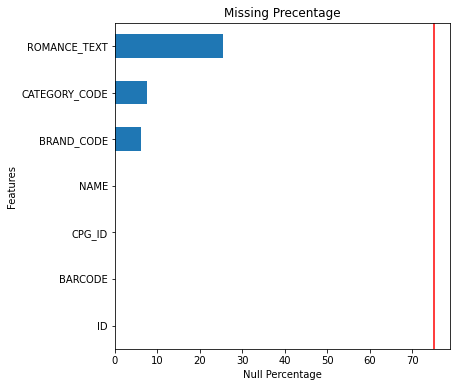

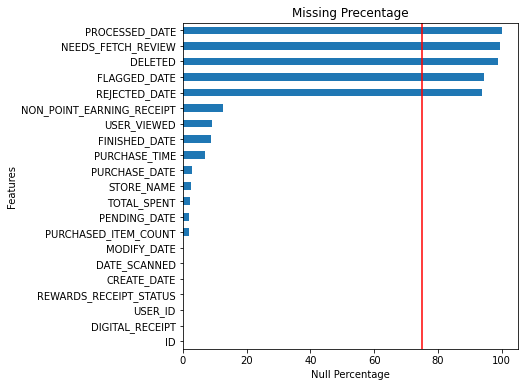

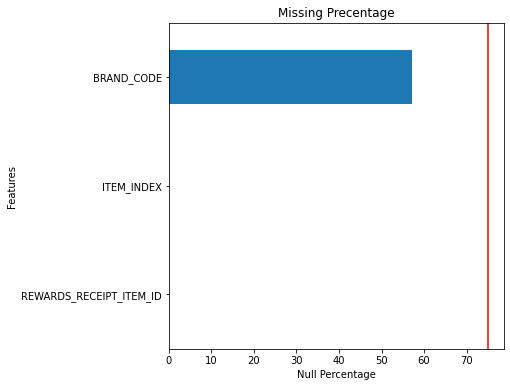

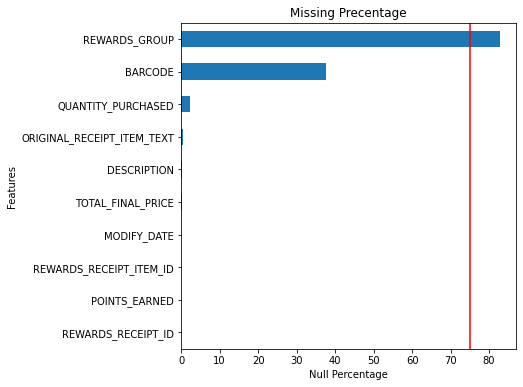

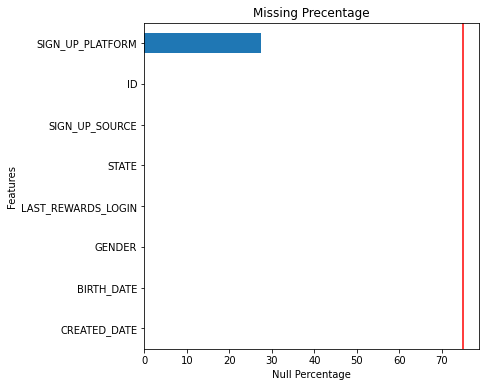

In [17]:
# check the missing precentage
for df in [brands, receipts, items, rewards, users]:
    plot_missing(df, 75)

In [18]:
receipts['DELETED'].unique()

array([nan, True], dtype=object)

Most high-missing precentage features are datetime features. We could take more logical inspection on these datetime features to fill the missing data.

We could see there are only two values, NaN and True, on "DELETED" column. We can infer that the undeleted rows were labelled NaN.

In [19]:
receipt_items['POINTS_EARNED'].unique()

array([0.0000e+00, 3.5000e+01, 3.9900e+01, 9.9900e+01, 2.2900e+01,
       1.3200e+01, 1.2480e+02, 1.0500e+02, 2.5900e+01, 1.6700e+01,
       5.9400e+01, 5.4800e+01, 3.7200e+01, 2.0000e+01, 3.3300e+01,
       6.4800e+01, 4.4900e+01, 1.4900e+01, 1.1900e+01, 5.9900e+01,
       2.1900e+01, 4.6900e+01, 1.8400e+01, 8.4800e+01, 2.5200e+01,
       5.9800e+01, 3.9800e+01, 1.4490e+02, 6.3700e+01, 2.1000e+02,
       3.2700e+01, 9.9000e+00, 6.1000e+00, 2.3100e+01, 1.3100e+01,
       4.9900e+01, 1.9900e+01, 1.5900e+01, 3.3900e+01, 1.2600e+01,
       3.3800e+01, 4.2800e+01, 2.2300e+01, 5.9700e+01, 5.9500e+01,
       1.3000e+01, 2.7000e+01, 4.0000e+01, 1.6000e+01, 1.2500e+02,
       2.9000e+01, 3.4000e+01, 5.0000e+01, 7.0000e+01, 1.2000e+02,
       5.0000e+00, 3.9600e+01, 2.1800e+01, 9.9800e+01, 1.5000e+01,
       4.0800e+01, 4.8800e+01, 4.2900e+01, 3.0000e+01, 4.8000e+01,
       3.4900e+01, 4.7700e+01, 4.2200e+01, 2.9900e+01, 1.3980e+02,
       1.1970e+02, 1.0470e+02, 7.4900e+01, 4.3300e+01, 6.4900e

We can say no zero value in the "POINTS_EARNED" column. And we infer that the actual nan value is 0.

In [20]:
rewards.describe()

,QUANTITY_PURCHASED,TOTAL_FINAL_PRICE,POINTS_EARNED
count,149671.000000,152771.000000,153076.000000
mean,1.579204,8.821878,2.588532
std,99.010608,148.359815,22.342632
min,-1.000000,0.000000,0.000000
25%,1.000000,1.780000,0.000000
50%,1.000000,3.500000,0.000000
75%,1.000000,7.160000,0.000000
max,36556.000000,31003.840000,3598.500000


We found that there are some negative value in 'QUANTITY_PURCHASED', which is not really reasonable. It can be inferred as a wrong input. 

### Basic Analysis

In [21]:
def calc_freq(df, col):
    frequence = 100*(df[col].value_counts()/len(df[~df[col].isna()]))
    # print(frequence)
    return frequence

def plot_freq(df, col):
    frequence = calc_freq(df, col)
    plt.figure(figsize = (6, 6))
    frequence.plot(kind='barh')
    plt.xlabel("Percentage")
    plt.ylabel("Features")
    plt.title("Frequency")
    plt.show()

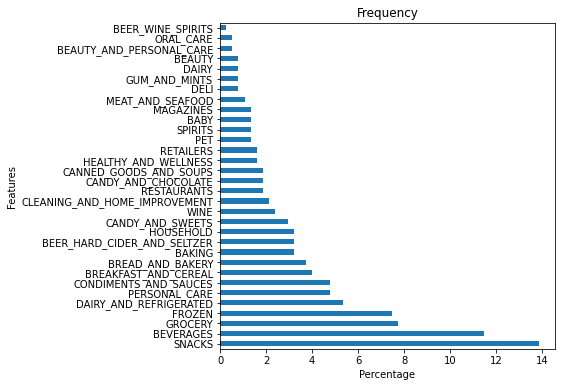

In [22]:
plot_freq(brands, "CATEGORY_CODE")

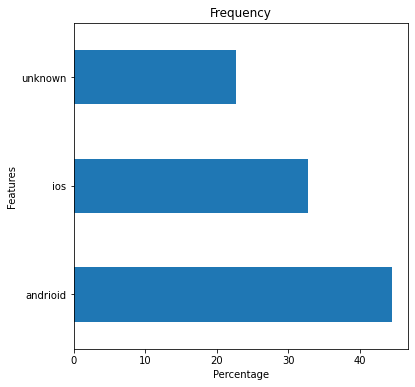

In [23]:
plot_freq(users, "SIGN_UP_PLATFORM")

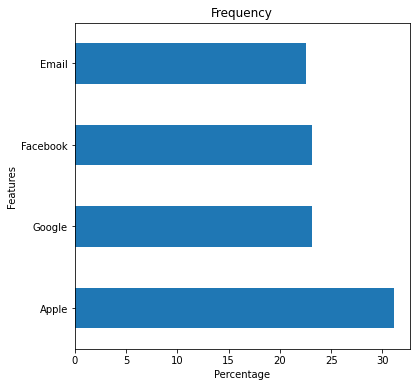

In [24]:
plot_freq(users, "SIGN_UP_SOURCE")

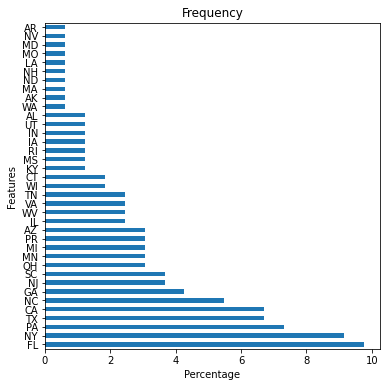

In [25]:
plot_freq(users, "STATE")

### Distribution

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='TOTAL_FINAL_PRICE'>

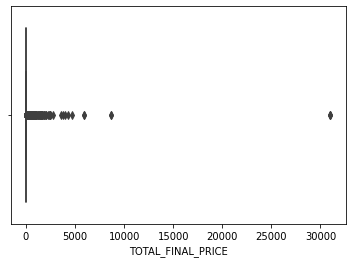

In [26]:
sns.boxplot(rewards["TOTAL_FINAL_PRICE"])

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='POINTS_EARNED'>

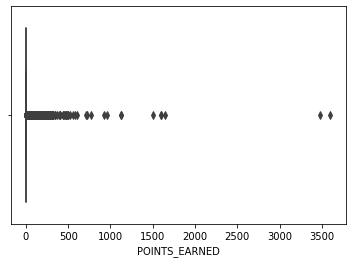

In [27]:
sns.boxplot(rewards["POINTS_EARNED"])

We can tell that the max value drives the mean and standard deviation extremly much away from without it. It can be a fault. Therefore, we can think about removing max value in the future analysis.

In [28]:
def exclude_max_then_outlier(series, sigma):
    series = series[series != series.max()]
    mean = series.mean()
    std = series.std()
    max = mean + std*sigma
    min = series.min()
    series = series.loc[lambda x : (x >= min) & (x < max)]
    return series

def exclude_outlier(series, sigma):
    mean = series.mean()
    std = series.std()
    max = mean + std*sigma
    min = series.min()
    series = series.loc[lambda x : (x >= min) & (x < max)]
    return series

def plot_distribution(df, col, sigma, bins):
    series = df[col]
    series = exclude_outlier(series, sigma)
    series.hist(bins=bins)
    plt.title(col+" distribution")
    plt.gca().grid(False) 
    plt.show()

def plot_distribution_nomax(df, col, sigma, bins):
    series = df[col]
    series = exclude_max_then_outlier(series, sigma)
    series.hist(bins=bins)
    plt.title(col+" distribution")
    plt.gca().grid(False) 
    plt.show()

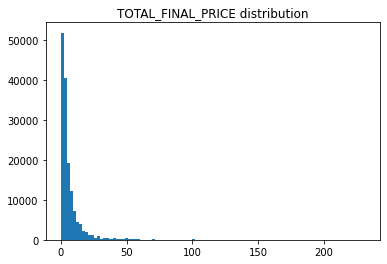

In [29]:
plot_distribution(rewards, "TOTAL_FINAL_PRICE", 1.5, 100)

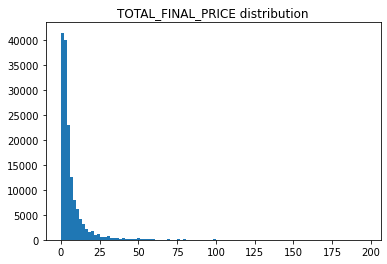

In [30]:
plot_distribution_nomax(rewards, "TOTAL_FINAL_PRICE", 1.5, 100)

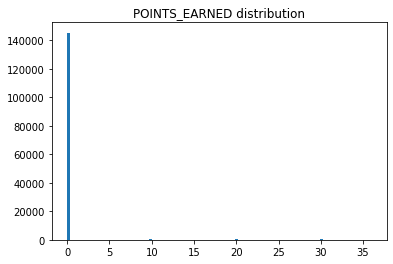

In [31]:
plot_distribution(rewards, "POINTS_EARNED", 1.5, 100)

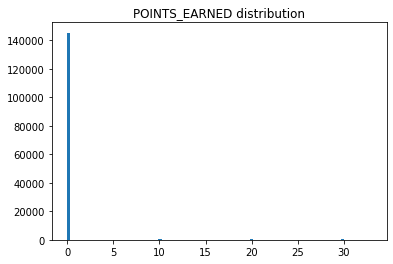

In [32]:
plot_distribution_nomax(rewards, "POINTS_EARNED", 1.5, 100)

### Query

Which brand saw the most dollars spent in the month of June?

Which user spent the most money in the month of August?

What user bought the most expensive item?

What is the name of the most expensive item purchased?

How many users scanned in each month?


In [33]:
"""
SELECT b.NAME, SUM(r.TOTAL_FINAL_PRICE) as total_spent
FROM brands b
JOIN items i ON b.BRAND_CODE = i.BRAND_CODE
JOIN rewards r ON i.REWARDS_RECEIPT_ITEM_ID = r.REWARDS_RECEIPT_ITEM_ID
JOIN receipts re ON r.REWARDS_RECEIPT_ID = re.ID
WHERE MONTH(re.PURCHASE_DATE) = 6
GROUP BY b.NAME
ORDER BY total_spent DESC
LIMIT 1;

"""

"""
SELECT u.ID, SUM(r.TOTAL_SPENT) as total_spent
FROM users u
JOIN receipts r ON u.ID = r.USER_ID
WHERE MONTH(r.PURCHASE_DATE) = 8
GROUP BY u.ID
ORDER BY total_spent DESC
LIMIT 1;
"""

"""
SELECT u.ID, r.TOTAL_FINAL_PRICE
FROM users u
JOIN receipts re ON u.ID = re.USER_ID
JOIN rewards rr ON re.ID = rr.REWARDS_RECEIPT_ID
JOIN items i ON rr.REWARDS_RECEIPT_ITEM_ID = i.REWARDS_RECEIPT_ITEM_ID
JOIN (SELECT MAX(TOTAL_FINAL_PRICE) AS max_price FROM Rewards) r
ON rr.TOTAL_FINAL_PRICE = r.max_price
ORDER BY r.TOTAL_FINAL_PRICE DESC
LIMIT 1;
"""

"""
SELECT ri.DESCRIPTION
FROM rewards r
JOIN receipt_items ri ON r.REWARDS_RECEIPT_ITEM_ID = ri.REWARDS_RECEIPT_ITEM_ID
WHERE r.TOTAL_FINAL_PRICE = (SELECT MAX(TOTAL_FINAL_PRICE) FROM Rewards);
"""

"""
SELECT MONTH(DATE_SCANNED) AS Month, COUNT(DISTINCT USER_ID) AS UsersScanned
FROM Receipts
GROUP BY MONTH(DATE_SCANNED);
"""

'\nSELECT MONTH(DATE_SCANNED) AS Month, COUNT(DISTINCT USER_ID) AS UsersScanned\nFROM Receipts\nGROUP BY MONTH(DATE_SCANNED);\n'

### Communication with stakeholder

Dear Stakeholders,

I am writing to bring to your attention some data quality issues that have been identified in our database. Specifically, we have noticed that there are a high-prcentage missing values in several key fields in the receipts, brands, and rewards tables. In addition, we have identified some extreme values in the rewards table.

1. In the receipts table, there are several records where the date and time of purchase are missing. It can be valubale for analyzing purchase patterns over time.

2. In the items table, we have identified a number of records where the brand code field is missing. This makes it difficult to link sales data to specific brands, and could impact our ability to make informed decisions about marketing and coopartion with these brands.

3. In the rewards table, we have identified extreme values in the points earned and total spent fields. These values appear to be outliers and could have an impact on our ability to accurately analyze the effectiveness of our rewards program.

4. Additionally, we have identified records where the rewards group and barcode fields are missing. These fields are critical for analyzing the effectiveness of our rewards program, and the missing data could have an impact on our ability to measure engagement and make informed decisions about program enhancements.

If you have any questions or concerns about these data quality issues, please do not hesitate to contact us.

Thank you for your attention to this matter.

Best regards,

Thomas